In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize
import scipy.stats
import scipy.ndimage
import matplotlib.pyplot as plt
from astropy.cosmology import Planck13
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

cosmo = Planck13

# Primary Analysis

In [2]:
# os.chdir("/home/mitchell/Documents/masters/masters/data/server/run_44/outputs")
# os.getcwd()
# output = np.loadtxt('output_546000_pairs.txt',delimiter=',')

In [3]:
os.chdir("/home/mitchell/Documents/masters/masters/data/server/run_45_lr_flip/outputs")
os.getcwd()
output = np.loadtxt('output_776000_pairs.txt',delimiter=',')
output = (output + np.flipud(output))/2
# output = (output+np.fliplr(output))/2

In [4]:
def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius
  return mask

cen = (169/2+1,169/2+1)
out_mask = radMask(cen,80,output).astype(int)
in_mask = radMask(cen,60,output).astype(int)
annul_mask = np.subtract(out_mask,in_mask).astype(bool)
annular_mean = sp.ndimage.mean(output,labels = annul_mask)
output_less_mean = output-annular_mean
# print(annular_mean)
# print(output_less_mean)
lft_halo = output[:,44]
centre = int(len(output)/2)+1



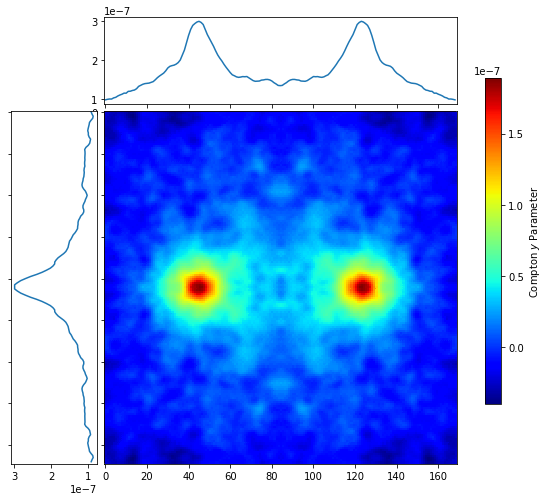

In [56]:
fig, axImage = plt.subplots(figsize=(10, 12))

axImage.imshow(output_less_mean)
divider = make_axes_locatable(axImage)
axSliceX = divider.append_axes("top", 1.2, pad=0.1, sharex=axImage)
axSliceY = divider.append_axes("left", 1.2, pad=0.1, sharey=axImage)

axSliceX.xaxis.set_tick_params(labelbottom=False)
axSliceY.yaxis.set_tick_params(labelleft=False)

axSliceY.invert_xaxis()

central_line_x = output[centre,:]
axSliceX.plot(central_line_x)

lft_halo = output[:,44]
axSliceY.plot(lft_halo,np.arange(len(lft_halo)))

im = axImage.pcolormesh(output_less_mean,cmap='jet')
fig.colorbar(im,ax=axImage,shrink=0.5,label='Compton $y$ Parameter')


os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
fig.savefig('Stack.png',dpi=700)
plt.show()
plt.close()

phys_output = output_less_mean

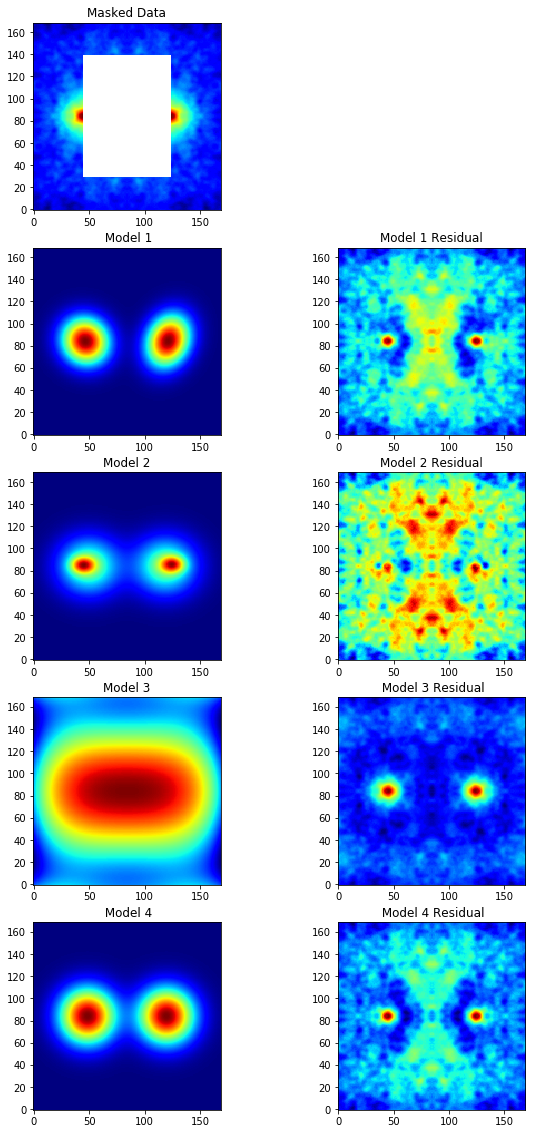

In [6]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

@custom_model
def sum_of_2Dgaussians(x, y, amplitude=1., mean_x1=0., mean_y1=0., mean_x2=0., mean_y2=0., sigma_x=1.,sigma_y=1.):
    return amplitude * np.exp(-( (x-mean_x1)**2/2./sigma_x**2 + (y-mean_y1)**2/2./sigma_y**2 ) ) \
        + amplitude * np.exp(-( (x-mean_x2)**2/2./sigma_x**2 + (y-mean_y2)**2/2./sigma_y**2 ) )

@custom_model
def spherical_of_2Dgaussians(x, y, amplitude=1., mean_x1=0., mean_y1=0., mean_x2=0., mean_y2=0., sigma=1.):
    return amplitude * np.exp(-( (x-mean_x1)**2/2./sigma**2 + (y-mean_y1)**2/2./sigma**2 ) ) \
        + amplitude * np.exp(-( (x-mean_x2)**2/2./sigma**2 + (y-mean_y2)**2/2./sigma**2 ) )

@custom_model
def sum_of_exponential_2D(x, y, decay_x = 0., cen_x1=0., cen_x2 = 0., decay_y = 0., cen_y1 = 0., cen_y2 = 0.):
    return (np.exp(- decay_x*(x-cen_x1) - decay_y*(y-cen_y1)) \
                      + np.exp(- decay_x*(x-cen_x2) - decay_y*(y-cen_y2)))

fit_data = np.ma.masked_array(output, mask=np.zeros_like(output))
fit_data.mask[30:169-30,45:169-45] = True 

# p_init = models.Polynomial2D(degree=4)
g1_init = models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Const2D(amplitude=1e-7) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=45, y_mean=85, x_stddev=5, y_stddev=5) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=125, y_mean=85, x_stddev=5, y_stddev=5) 
fit_g1 = fitting.LevMarLSQFitter()

g2_init = sum_of_2Dgaussians(amplitude=1e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \
    + sum_of_2Dgaussians(amplitude=4e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \
    + models.Const2D(amplitude=1e-7)
fit_g2 = fitting.LevMarLSQFitter()

g3_init = models.Polynomial2D(degree=4)#*\
#    sum_of_exponential_2D(amplitude=4e-7, decay_x = 12, cen_x1=45, cen_x2 = 125, decay_y = 12, cen_y1 = 85, cen_y2 = 85)
fit_g3 = fitting.LevMarLSQFitter()

g4_init = spherical_of_2Dgaussians(amplitude=1e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma=12) \
    + models.Const2D(amplitude=1e-7)
fit_g4 = fitting.LevMarLSQFitter()

y,x = np.mgrid[:len(output),:len(output)]

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    g1 = fit_g1(g1_init, x, y, fit_data)
    g2 = fit_g2(g2_init,x,y,fit_data)
    g3 = fit_g3(g3_init,x,y,fit_data)
    g4 = fit_g4(g4_init,x,y,fit_data)



    
plt.figure(figsize=(10,20))
plt.title("2D Model Fitting",size=15)
plt.subplot(5, 2, 1)
plt.imshow(fit_data, origin='lower', interpolation='nearest',cmap='jet')
plt.title("Masked Data")

plt.subplot(5, 2, 3)
plt.imshow(g1(x, y), origin='lower', interpolation='nearest',cmap='jet')
plt.title(" Model 1")

plt.subplot(5, 2, 4)
plt.imshow(output_less_mean - g1(x, y), origin='lower', interpolation='nearest',cmap='jet')
plt.title("Model 1 Residual")

plt.subplot(5, 2, 5)
plt.imshow(g2(x,y), origin='lower', interpolation='nearest',cmap='jet')
plt.title(r"Model 2")

plt.subplot(5,2,6)
plt.imshow(output_less_mean-g2(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(r"Model 2 Residual")

plt.subplot(5,2,7)
plt.imshow(g3(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title("Model 3")

plt.subplot(5,2,8)
plt.imshow(output_less_mean-g3(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(" Model 3 Residual")

plt.subplot(5,2,9)
plt.imshow(g4(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(" Model 4")

plt.subplot(5,2,10)
plt.imshow(output_less_mean-g4(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title(" Model 4 Residual")

plt.savefig("2D_data_fitting.png",dpi=800)

In [7]:
print(g1)
print(g2)

Model: CompoundModel3
Inputs: (u'x', u'y')
Outputs: (u'z',)
Model set size: 1
Expression: [0] + [1] + [2] + [3] + [4]
Components: 
    [0]: <Gaussian2D(amplitude=0.0000001, x_mean=45., y_mean=85., x_stddev=20., y_stddev=20., theta=0.)>

    [1]: <Gaussian2D(amplitude=0.0000001, x_mean=45., y_mean=85., x_stddev=20., y_stddev=20., theta=0.)>

    [2]: <Const2D(amplitude=0.0000001)>

    [3]: <Gaussian2D(amplitude=0.0000004, x_mean=45., y_mean=85., x_stddev=5., y_stddev=5., theta=0.)>

    [4]: <Gaussian2D(amplitude=0.0000004, x_mean=125., y_mean=85., x_stddev=5., y_stddev=5., theta=0.)>
Parameters:
         amplitude_0            x_mean_0      ...      theta_4      
    ---------------------- ------------------ ... ------------------
    -0.0001446206491282588 11488.100658125579 ... 12890068942.138083
Model: CompoundModel5
Inputs: ('x', 'y')
Outputs: ('x',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <sum_of_2Dgaussians(amplitude=0.0000001, mean_x1=45., mean_y1=85

Mean Filament Signal = -1.1376374717879953e-07
Std Dev Filament Signal = 1.8862778870413595e-08


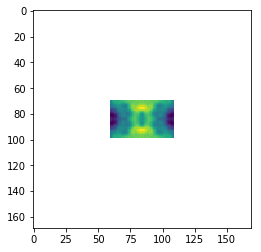

In [8]:
model = g4
filament = np.ma.masked_array(output_less_mean - model(x, y), mask=np.zeros_like(output))
filament.mask = True
filament.mask[70:169-70,60:169-60] = False
plt.imshow(filament)
model_fit = np.ma.masked_array(model(x, y), mask=np.zeros_like(output))
model_fit.mask = True
model_fit.mask[70:169-70,60:169-60] = False
print("Mean Filament Signal = " +str(sp.mean(filament)))
print("Std Dev Filament Signal = " +str(sp.std(model_fit)))

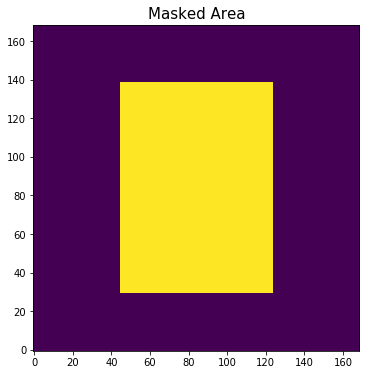

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(fit_data.mask,origin='lower')
plt.title("Masked Area",size=15)
plt.savefig("mask.png",dpi=200)

In [10]:

# annular_mean = sp.ndimage.mean(output,labels = mask)
# print(annular_mean)

In [11]:
# plt.imshow(output[:,:]-annular_mean)
# plt.colorbar()
def radial_dist(loc,array):
    x,y = np.meshgrid(np.arange(array.shape[1]),np.arange(array.shape[0]))
    R = np.sqrt((x-loc[0])**2+(y-loc[1])**2).astype(int)
    return R

In [12]:
# qtr = output[:len(output)/2,:len(output)/2]
# # plt.imshow(qtr)
# # x,y = np.meshgrid(np.arange(qtr.shape[1]),np.arange(qtr.shape[0]))
# # R = np.sqrt((x-44)**2+(y-85)**2).astype(int)
# # print(R)
# # plt.imshow(R)
# radii = radial_dist((44,85),qtr)
# plt.imshow(radii)
# # print(radii)
# plt.close()

# r_lam = lambda r : qtr[(R >= r-.02) & (R < r+.02)].mean()
# ar = np.linspace(1,95,num=95)
# means = np.vectorize(r_lam)(ar)
# plt.plot(means)

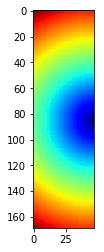

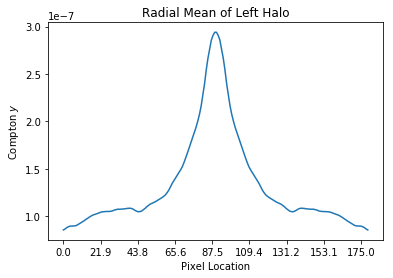

In [13]:
cut = output[:,:47]
radii = radial_dist((47,85),cut)
plt.imshow(radii,cmap='jet')
plt.show()
plt.close()
r_lam = lambda r : cut[(radii >= r-1.5) & (radii < r+1.5)].mean()
r_std = lambda m : cut[(radii >= m-1.5) & (radii < m+1.5)].std()
ar = np.linspace(1,90,num=90)
means = np.vectorize(r_lam)(ar)
mean_ref = means[::-1]

std_devs = np.vectorize(r_std)(ar)
relect = std_devs[::-1]
halo_stdev = np.concatenate((relect,std_devs))

halo = np.concatenate((mean_ref,means))
plt.plot(halo)
# plt.plot(halo_stdev)
# plt.errorbar(np.arange(len(halo)),halo,halo_stdev,ecolor='r',errorevery=3)
plt.title("Radial Mean of Left Halo")
plt.xlabel("Pixel Location")
plt.xticks(np.linspace(0,175,num=9),label=np.linspace(-85,85,num=9))
plt.ylabel(r"Compton $y$")
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.savefig("halo_shape.png")

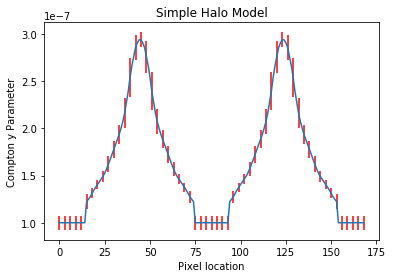

In [14]:
peak = halo[60:len(halo)-60]
height = peak[0]
two_halos = np.full_like(output[44],fill_value=1e-7)
two_halos[15:75] = peak
two_halos[-75:-15] = peak

peak_err = halo_stdev[60:len(halo)-60]
err_height = peak_err[0]
two_halo_err = np.full_like(output[44],fill_value=err_height)
two_halo_err[15:75] = peak_err
two_halo_err[-75:-15] = peak_err

plt.errorbar(np.arange(len(two_halos)),two_halos,two_halo_err,ecolor='r',errorevery=3)
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.title('Simple Halo Model')
plt.xlabel('Pixel location')
plt.ylabel('Compton y Parameter')
plt.savefig("halo_model_basic.png",dpi=400)

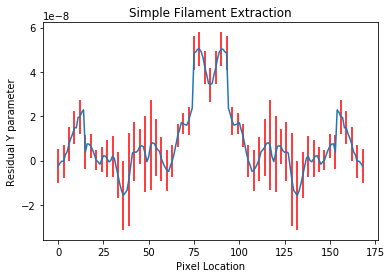

In [15]:
plt.errorbar(np.arange(len(central_line_x)),central_line_x-two_halos,two_halo_err,ecolor='r',errorevery=3)
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.title('Simple Filament Extraction')
plt.xlabel('Pixel Location')
plt.ylabel('Residual Y parameter')
plt.savefig("filament_basic.png",dpi=400)

In [16]:
residual = central_line_x-two_halos
print("Mean = " + str(np.mean(residual[60:-60])))
print("Error = " + str(np.mean(two_halo_err[60:-60])))
mean_compton_1 = np.mean(residual[60:-60])
std_compton_1 = np.mean(two_halo_err[60:-60])
sigma_1 = mean_compton_1/std_compton_1
print("Sigma 1 = " + str(sigma_1))

Mean = 2.3579191186117607e-08
Error = 6.900473585595068e-09
Sigma 1 = 3.4170395544067915


In [17]:
centre = int(len(output)/2)+1
print(centre)
central_line_x = output[centre,:]
# central_line_x_1 = output[centre,30:60]
# central_line_x_2 = output[centre,110:140]
central_line_y = output[:,centre]

85


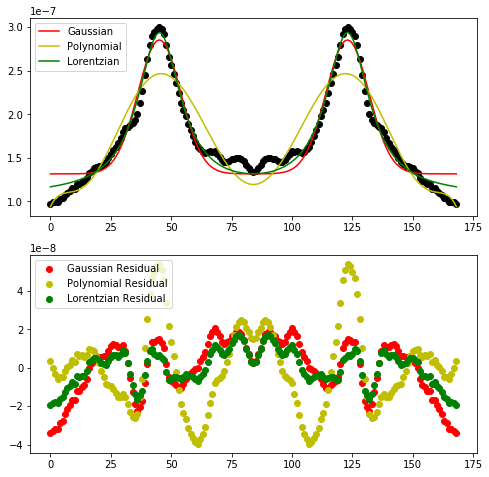

In [18]:
y_array_gauss = central_line_x
x_array = np.arange(len(central_line_x))

@custom_model
def exponentials(x, amplitude=1., decay_x = 0., cen_x1=0.):
    return amplitude*(np.exp(- decay_x*(x-cen_x1)))


p_init = models.Polynomial1D(degree=8)\
    + models.Const1D(amplitude = 1e-7)
#*exponentials(amplitude=4e-7,decay_x = 12, cen_x1 = 70) \
p_fit = fitting.LevMarLSQFitter()

p = p_fit(p_init,x_array,y_array_gauss)

g_init = models.Gaussian1D(amplitude=4e-7, mean=45, stddev=2.)\
    + models.Gaussian1D(amplitude=4e-7, mean=125, stddev=2.)\
    + models.Const1D(amplitude=1e-7)


#  models.Gaussian1D(amplitude=1e-7, mean=45, stddev=10.)
#  + models.Gaussian1D(amplitude=1e-7, mean=125, stddev=10.) \

fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x_array, y_array_gauss)

l_init = models.Lorentz1D(amplitude=4e-7, x_0=45, fwhm=2.)\
    + models.Lorentz1D(amplitude=4e-7, x_0=125, fwhm=2.)\
    + models.Const1D(amplitude=1e-7)

fit_l = fitting.LevMarLSQFitter()
l = fit_l(l_init, x_array, y_array_gauss)

    
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(x_array, y_array_gauss, 'ko')
plt.plot(x_array, g(x_array), 'r-',label='Gaussian')
plt.plot(x_array,p(x_array),'y-',label='Polynomial')
plt.plot(x_array,l(x_array),'g-',label='Lorentzian')
plt.legend(loc=2)

plt.subplot(2,1,2)
plt.plot(y_array_gauss-g(x_array),'ro',label='Gaussian Residual')
plt.plot(y_array_gauss-p(x_array),'yo',label='Polynomial Residual')
plt.plot(y_array_gauss-l(x_array),'go',label='Lorentzian Residual')
plt.legend(loc=2)
plt.savefig("halo_model_complex.png",dpi=400)

In [19]:
residual = y_array_gauss-g(x_array)
print("Mean = " + str(np.mean(residual[60:-60])))
print("Std Dev = " + str(np.std(residual[60:-60])))
mean_compton_2 = np.mean(residual[60:-60])
std_compton_2 = np.std(residual[60:-60])
sigma_2 = mean_compton_2/std_compton_2
print("Sigma 2 = " + str(sigma_2))

Mean = 1.2102032196555865e-08
Std Dev = 6.285289142243807e-09
Sigma 2 = 1.925453534860851


In [20]:
os.chdir('/home/mitchell/Documents/masters/masters/data/')
glob.glob('*')

['spt_sz_DES_catalogue.pkl',
 'galaxy_pairs.pkl',
 'UnPhysical_Redshift_Distribution.png',
 'cut_catalogue.pkl',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_090ghz.h5',
 'source_J2341_5119_90ghz.png',
 'UP_TRV_Separation.png',
 'unphysical_cat_2.pkl',
 'pairs.csv',
 'unphysical_cat_4.pkl',
 'DES_REDMAGIC_Manipulated.csv',
 'y_map.npy',
 'ra0dec-57p5_sum1000_090ghz.h5',
 'ra0dec-57p5_sum5000_150ghz.h5',
 'compton_y_map.png',
 'source_J2341_5119_150ghz.png',
 'high_res_map.png',
 'unphysical_pairs_4.pkl',
 'y_map.h5',
 'high_res.h5',
 'unphysical_cat_3.pkl',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_150ghz.h5',
 'unphysical_pairs_3.pkl',
 'Redshift_Distribution.png',
 'ra0dec-57p5_sum100Weighted_150ghz.h5',
 'LOS_Separation.png',
 'cutouts.pkl.gz',
 'cr_coadds',
 'redmagic_sva1_public_v6.3_faint.fits',
 'sri_J2337_5942_diff.png',
 'ra0dec-57p5_sum1000_150ghz.h5',
 'source_2337_5942_90ghz.png',
 'scratch',
 'ra0dec-57p5_sum_150ghz.h5',
 'Run_1',
 'planck2015',
 'ra0dec-57p5_sum100Weight

In [21]:
pairs = pd.read_pickle('spt_pol_pairs.pkl')

In [22]:
cat = pd.read_pickle('spt_pol_DES_catalogue.pkl')

In [23]:
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
# pairs.DEL_THETA.describe()

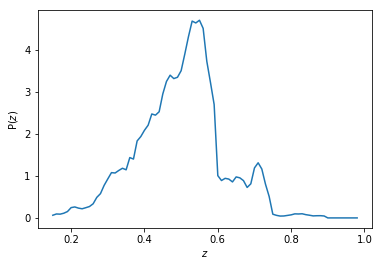

In [44]:
mean_redshift = np.mean([pairs.Z1,pairs.Z2],axis=0)
redshift_pdf = plt.hist(mean_redshift, density=True,stacked=True ,cumulative=False,label='Redshift PDF', histtype = 'step'
                        , alpha = 0.8,color = 'k',bins=np.arange(0.15,1.0,0.01))
plt.close()
plt.plot(redshift_pdf[1][:len(redshift_pdf[0])],redshift_pdf[0])
plt.xlabel('$z$')
plt.ylabel('P($z$)')
plt.savefig('Redshift_Distribution.png',dpi=400)
sp.stats.describe(mean_redshift)
pairs_red_pdf = redshift_pdf[0]

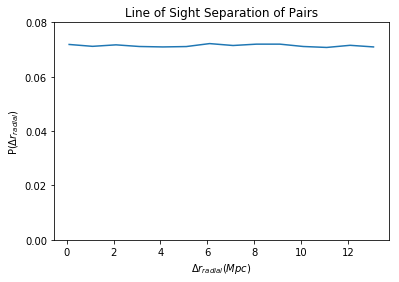

In [45]:
sep_los_pdf = plt.hist(pairs.SEP_LOS, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(0.1,14.5,1))
plt.close()
plt.plot(sep_los_pdf[1][:len(sep_los_pdf[0])],sep_los_pdf[0])
plt.xlabel('$\Delta r_{radial} (Mpc)$')
plt.ylabel('P($\Delta r_{radial}$)')
plt.ylim([0.0,0.08])
plt.yticks([0.0,0.02,0.04,0.06,0.08])
plt.title('Line of Sight Separation of Pairs')
plt.savefig('LOS_Separation.png',dpi=400)
pairs.SEP_LOS.describe()
pairs_los_pdf = sep_los_pdf[0]

11


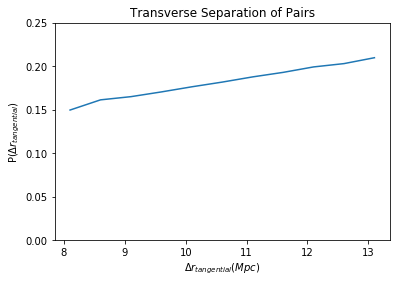

In [51]:
sep_trv_pdf = plt.hist(pairs.SEP_TRV, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(8.1,14.1,0.5))
plt.close()
plt.plot((sep_trv_pdf[1][:len(sep_trv_pdf[0])]),sep_trv_pdf[0])
plt.xlabel('$\Delta r_{tangential} (Mpc)$')
plt.ylabel('P($\Delta r_{tangential}$)')
plt.ylim([0.0,0.25])
# plt.yticks([0.0,0.02,0.04,0.06,0.08])
plt.title('Transverse Separation of Pairs')
plt.savefig('TRV_Separation.png',dpi=400)
pairs.SEP_TRV.describe()
pairs_trv_pdf = sep_trv_pdf[0]
print(len(pairs_trv_pdf))

In [27]:
cat.ZREDMAGIC.describe()

count    99609.000000
mean         0.515210
std          0.159174
min          0.150070
25%          0.405930
50%          0.518504
75%          0.620101
max          0.899987
Name: ZREDMAGIC, dtype: float64

In [28]:
sp.stats.describe(np.rad2deg(pairs.DEL_THETA)*60)

DescribeResult(nobs=787058, minmax=(6.5228528769207275, 59.9647340803106), mean=27.5613357822448, variance=85.27798807003148, skewness=0.26631906984923154, kurtosis=-0.17476725429376083)

In [29]:
# sp.stats.describe(pairs.S*cosmo.h)

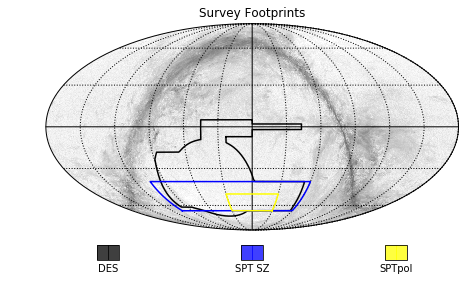

In [30]:
os.chdir("/home/mitchell/Documents/masters/masters/scripts")
from cmb_footprint import footprint
fp = footprint.SurveyStack('PLANCK-DUSTPOL', projection='mollweide', coord_plot='C', rot=[0,0],
                           config='/home/mitchell/Documents/masters/masters/scripts/cmb_footprint/footprint.cfg') 

fp.superimpose_survey_outline('DES-polygon', color='black', label='DES')
fp.superimpose_survey_outline('SPT-SZ-tot', color='blue',label='SPT SZ')
fp.superimpose_survey_outline('SPTpol', color='yellow')#,label='SPTpol')
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
plt.savefig("Survey_Outlines.png",dpi=500)

In [31]:
os.chdir('/home/mitchell/Documents/masters/masters/data/server/run_42/steps/')
firstcut = np.loadtxt('1_firstcut.txt',delimiter = ',')
rotated = np.loadtxt('1_rotated.txt',delimiter = ',')
rescaled = np.loadtxt('1_rescaled.txt',delimiter = ',')
second_cut = np.loadtxt('1_secondcut.txt',delimiter = ',')

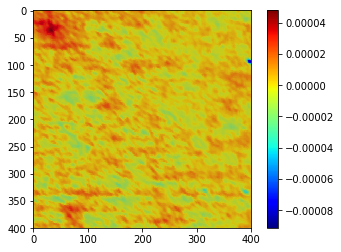

In [32]:
plt.imshow(firstcut,cmap='jet')
plt.colorbar()
mask = np.zeros_like(firstcut)
plt.imshow(mask,alpha=0.2)

# Unphysical Stacks

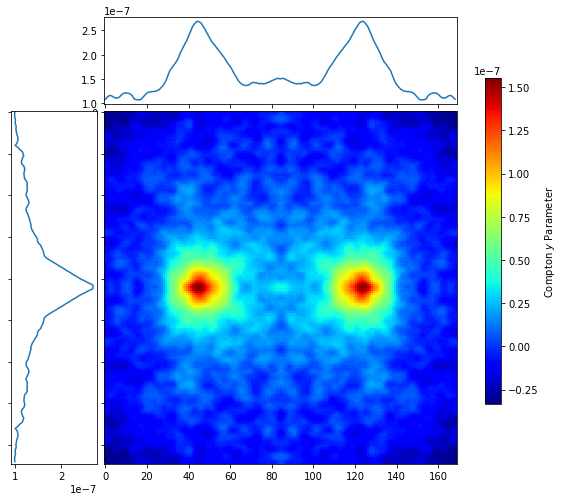

In [57]:
os.chdir("/home/mitchell/Documents/masters/masters/data/server/nulls/unphysical/run_5/outputs")
p
up_output = np.loadtxt('output_776000_pairs.txt',delimiter=',')
up_output = (up_output+np.flipud(up_output))/2

cen = (169/2+1,169/2+1)
out_mask = radMask(cen,80,up_output).astype(int)
in_mask = radMask(cen,60,up_output).astype(int)
annul_mask = np.subtract(out_mask,in_mask).astype(bool)
annular_mean = sp.ndimage.mean(up_output,labels = annul_mask)
up_less_mean = up_output-annular_mean
# print(annular_mean)
# print(output_less_mean)
lft_halo = output[:,44]
centre = int(len(output)/2)+1

fig, axImage = plt.subplots(figsize=(10, 12))

axImage.imshow(up_less_mean)
divider = make_axes_locatable(axImage)
axSliceX = divider.append_axes("top", 1.2, pad=0.1, sharex=axImage)
axSliceY = divider.append_axes("left", 1.2, pad=0.1, sharey=axImage)

axSliceX.xaxis.set_tick_params(labelbottom=False)
axSliceY.yaxis.set_tick_params(labelleft=False)

central_line_x = up_output[centre,:]
axSliceX.plot(central_line_x)

lft_halo = up_output[:,44]
axSliceY.plot(lft_halo,np.arange(len(lft_halo)))

im = axImage.pcolormesh(up_less_mean,cmap='jet')
clb = fig.colorbar(im,ax=axImage,shrink=0.5,label='Compton $y$ Parameter')
# clb.ax.set_title('Compton $y$')
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
fig.savefig('UnPhysical_Stack.png',dpi=800)
plt.show()
plt.close()

unphys_output = up_less_mean

Text(0.5,1,'Second Residual')

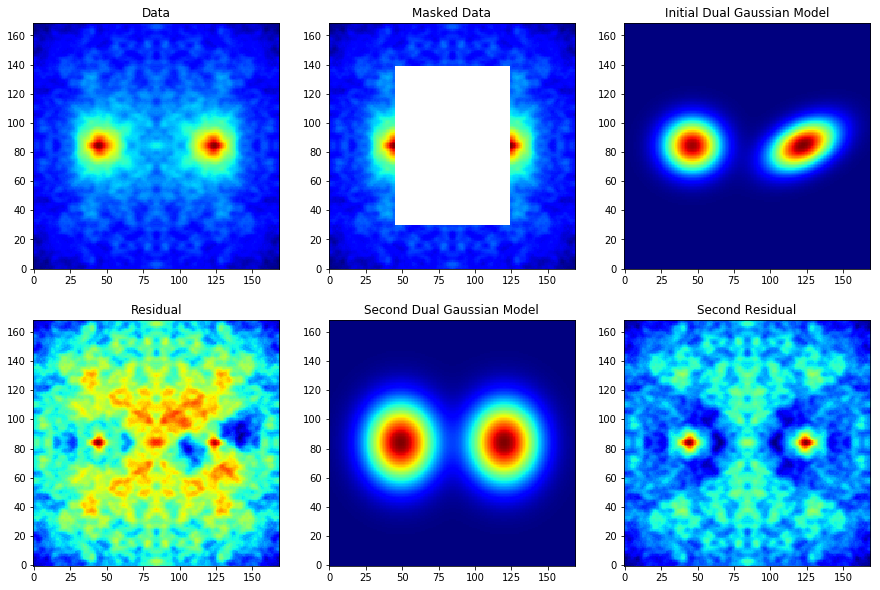

In [35]:
fit_data = np.ma.masked_array(up_less_mean, mask=np.zeros_like(output))
fit_data.mask[30:169-30,45:169-45] = True 

# p_init = models.Polynomial2D(degree=4)
g1_init = models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Gaussian2D(amplitude=1e-7, x_mean=45, y_mean=85, x_stddev=20, y_stddev=20) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=45, y_mean=85, x_stddev=5, y_stddev=5) \
    + models.Gaussian2D(amplitude=4e-7, x_mean=125, y_mean=85, x_stddev=5, y_stddev=5) \
    + models.Const2D(amplitude=1e-6) 
fit_g1 = fitting.LevMarLSQFitter()

g2_init = sum_of_2Dgaussians(amplitude=1e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \
    + models.Const2D(amplitude=1e-7)
#  + sum_of_2Dgaussians(amplitude=4e-7, mean_x1=45, mean_x2=125, mean_y1=85, mean_y2=85, sigma_x=12, sigma_y=12) \?
fit_g2 = fitting.LevMarLSQFitter()

y,x = np.mgrid[:len(up_less_mean),:len(up_less_mean)]

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    g1 = fit_g1(g1_init, x, y, fit_data)
    g2 = fit_g2(g2_init,x,y,fit_data)


    
plt.figure(figsize=(15,10))
plt.subplot(2, 3, 1)
plt.imshow(up_less_mean, origin='lower', interpolation='nearest',cmap='jet')
plt.title("Data")

plt.subplot(2, 3, 2)
plt.imshow(fit_data, origin='lower', interpolation='nearest',cmap='jet')
plt.title("Masked Data")

plt.subplot(2, 3, 3)
plt.imshow(g1(x, y), origin='lower', interpolation='nearest',cmap='jet')
plt.title("Initial Dual Gaussian Model")

plt.subplot(2, 3, 4)
plt.imshow(up_less_mean - g1(x, y), origin='lower', interpolation='nearest',cmap='jet')
plt.title("Residual")

plt.subplot(2,3,5)
plt.imshow(g2(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title("Second Dual Gaussian Model")

plt.subplot(2,3,6)
plt.imshow(up_less_mean-g2(x,y),origin='lower',interpolation='nearest',cmap='jet')
plt.title("Second Residual")

# plt.savefig("unphysical_fit.png")

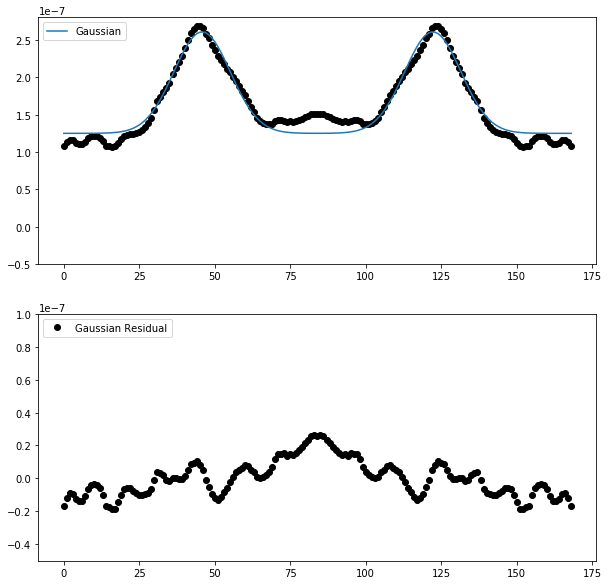

In [55]:
y_array_gauss = central_line_x
x_array = np.arange(len(central_line_x))

p_init = models.Polynomial1D(degree=8) + models.Const1D(amplitude = 1e-7)
p_fit = fitting.LevMarLSQFitter()

p = p_fit(p_init,x_array,y_array_gauss)

g_init = models.Gaussian1D(amplitude=4e-7, mean=45, stddev=2.)\
    + models.Gaussian1D(amplitude=4e-7, mean=125, stddev=2.)\
    + models.Const1D(amplitude=1e-7)

#  models.Gaussian1D(amplitude=1e-7, mean=45, stddev=10.)
#  + models.Gaussian1D(amplitude=1e-7, mean=125, stddev=10.) \

fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x_array, y_array_gauss)
    
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(x_array, y_array_gauss, 'ko')
plt.plot(x_array, g(x_array), label='Gaussian')
plt.ylim([-0.5e-7,2.8e-7])
# plt.plot(x_array,p(x_array),label='Polynomial')
plt.legend(loc=2)

plt.subplot(2,1,2)
plt.plot(y_array_gauss-g(x_array),'ko',label='Gaussian Residual')
# plt.plot(y_array_gauss-p(x_array),'ro',label='Polynomial')
plt.legend(loc=2)
plt.ylim([-0.5e-7,1e-7])
plt.savefig("unphysical_halo_fit.png",dpi=400)

In [37]:
sp.stats.describe(y_array_gauss-g(x_array))

DescribeResult(nobs=169, minmax=(-1.8517783774374475e-08, 2.644659279311954e-08), mean=1.2860225733177904e-18, variance=1.2071923572865904e-16, skewness=0.46985997933481644, kurtosis=-0.45304465377599046)

DescribeResult(nobs=6608799, minmax=(0.16830996423959732, 0.8721328973770142), mean=0.4999733359311405, variance=0.012425804456299231, skewness=0.030418209908128737, kurtosis=0.02385935492147695)


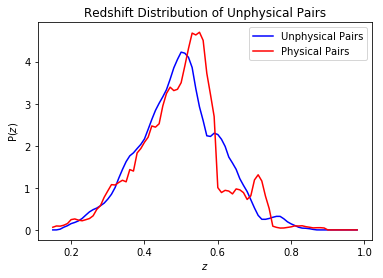

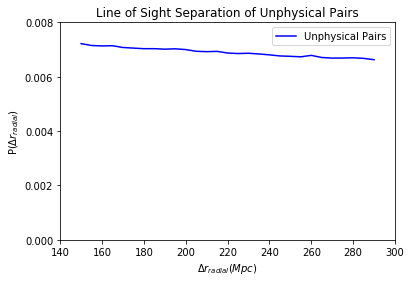

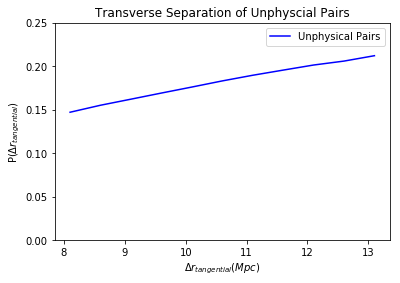

In [53]:
os.chdir('/home/mitchell/Documents/masters/masters/data/')
un_pairs = pd.read_pickle('spt_pol_unphysical.pkl')

os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')


mean_redshift = np.mean([un_pairs.Z1,un_pairs.Z2],axis=0)
redshift_pdf = plt.hist(mean_redshift, density=True,stacked=True ,cumulative=False,label='Redshift PDF', histtype = 'step'
                        , alpha = 0.8,color = 'k',bins=np.arange(0.15,1.0,0.01))
plt.close()
plt.plot(redshift_pdf[1][:len(redshift_pdf[0])],redshift_pdf[0],'b',label='Unphysical Pairs')
plt.plot(redshift_pdf[1][:len(redshift_pdf[0])],pairs_red_pdf,'r',label='Physical Pairs')
plt.xlabel('$z$')
plt.ylabel('P($z$)')
plt.title("Redshift Distribution of Unphysical Pairs")
plt.legend()
plt.savefig('UnPhysical_Redshift_Distribution.png',dpi=400)
print(sp.stats.describe(mean_redshift))
plt.show()
plt.close()

sep_los_pdf = plt.hist(un_pairs.SEP_LOS, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(150,300,5))
plt.close()
plt.plot(sep_los_pdf[1][:len(sep_los_pdf[0])],sep_los_pdf[0],'b',label='Unphysical Pairs')
# plt.plot(redshift_pdf[1][:len(redshift_pdf[0])],pairs_los_pdf,'r',label='Physical Pairs')
plt.xlabel('$\Delta r_{radial} (Mpc)$')
plt.ylabel('P($\Delta r_{radial}$)')
plt.xlim([140.0,300.0])
plt.ylim([0.0,0.008])
plt.yticks([0.0,0.002,0.004,0.006,0.008])
plt.legend()
plt.title('Line of Sight Separation of Unphysical Pairs')
plt.savefig('UP_LOS_Separation.png',dpi=400)
plt.show()
plt.close()

sep_trv_pdf = plt.hist(un_pairs.SEP_TRV, normed=True, cumulative=False, label='PDF',
         histtype='step', alpha=0.8, color='k',bins=np.arange(8.1,14.1,0.5))
plt.close()
# print(len(sep_trv_pdf[0]))
plt.plot((sep_trv_pdf[1][:len(sep_trv_pdf[0])]),sep_trv_pdf[0],'b',label='Unphysical Pairs')
# plt.plot(redshift_pdf[1][:len(redshift_pdf[0])],pairs_trv_pdf,'r',label='Physical Pairs')
plt.xlabel('$\Delta r_{tangential} (Mpc)$')
plt.ylabel('P($\Delta r_{tangential}$)')
plt.ylim([0.0,0.25])
plt.legend()
# plt.yticks([0.0,0.02,0.04,0.06,0.08])
plt.title('Transverse Separation of Unphyscial Pairs')
plt.savefig('UP_TRV_Separation.png',dpi=400)
plt.show()
plt.close()

In [ ]:
un_pairs.describe()

# Random Locations

In [ ]:
os.chdir("/home/mitchell/Documents/masters/masters/data/server/nulls/rand_pos/run_2/outputs")
os.getcwd()
# %ls
up_output = np.loadtxt('output_341000_pairs.txt',delimiter=',')

cen = (169/2+1,169/2+1)
out_mask = radMask(cen,80,up_output).astype(int)
in_mask = radMask(cen,60,up_output).astype(int)
annul_mask = np.subtract(out_mask,in_mask).astype(bool)
annular_mean = sp.ndimage.mean(up_output,labels = annul_mask)
up_less_mean = up_output-annular_mean
# print(annular_mean)
# print(output_less_mean)
lft_halo = output[:,44]
centre = int(len(output)/2)+1

fig, axImage = plt.subplots(figsize=(10, 12))

axImage.imshow(up_less_mean)
divider = make_axes_locatable(axImage)
axSliceX = divider.append_axes("top", 1.2, pad=0.1, sharex=axImage)
axSliceY = divider.append_axes("left", 1.2, pad=0.1, sharey=axImage)

axSliceX.xaxis.set_tick_params(labelbottom=False)
axSliceY.yaxis.set_tick_params(labelleft=False)

central_line_x = up_output[centre,:]
axSliceX.plot(central_line_x)

lft_halo = up_output[:,44]
axSliceY.plot(lft_halo,np.arange(len(lft_halo)))

im = axImage.pcolormesh(up_less_mean,cmap='jet',vmax=2e-7,vmin=-0.25e-7)
clb = fig.colorbar(im,ax=axImage,shrink=0.5,label='Compton $y$ Parameter')
# clb.ax.set_title('Compton $y$')
os.chdir('/home/mitchell/Documents/masters/masters/thesis/Ver_2/figures')
fig.savefig('Rand_Pos_Stack.png',dpi=800)
plt.show()
plt.close()


In [ ]:
import astropy.units as u
def rho_b(z):
    return cosmo.critical_density0*cosmo.Ob0*(1+z)**3
def mean_n_e(z):
    return rho_b(z)*(1+0.76)/(2*1.67e-24*u.gram)
def n_e(z):
    return 6*mean_n_e(z)

In [ ]:
n_e(0.47)

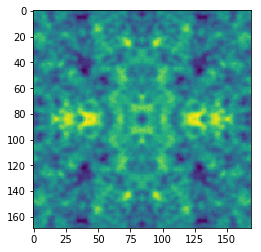

In [58]:
plt.imshow(phys_output-unphys_output)